## Part 1: Image segmentation exploration

In [ ]:
import sys
import os
print(sys.prefix)

from random import randint
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
print(torch.__version__)
from torchvision import transforms, datasets, models

# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# from pycocotools.coco import COCO

/usr
1.7.0+cu101


Clone torchvision segmentation tools 

In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
cp -r references/segmentation/. ../
cd ../
ls

Cloning into 'vision'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 14218 (delta 187), reused 170 (delta 110), pack-reused 13938
Receiving objects: 100% (14218/14218), 15.76 MiB | 24.41 MiB/s, done.
Resolving deltas: 100% (9975/9975), done.
coco_utils.py  README.md    train.py	   utils.py
presets.py     sample_data  transforms.py  vision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cp '/content/drive/MyDrive/_mobilenet.py' '/content/'


Mounted at /content/drive


### 1. Examine COCO datasets with pycocotools [Section removed in this Ver]

### 2. inference on pretrained segmentation model, and display masks

In [ ]:
# make display model predictions helper functions
def rgb_mask(image, nc=21):
    '''
    convert 2d image with class labels to RGB image, where each label is mapped to color
    :params: image: HxW matrix
    :return: rgb: 3xHxW matrix
    ''' 
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def display_seg_map(preds, dataset, idx):
    class_map = torch.argmax(preds.squeeze(), dim=0).detach().cpu().numpy()
    #print(class_map.shape)
    
    # Positive segmentation classes of total 20+1 pascal classes
    classes = np.unique(class_map)#.tolist().remove(0)
    #  NOTE: catsID remapped during training, cant use loadCats ard
    # cats = dataset.coco.loadCats(classes)
    rgb = rgb_mask(class_map)    
    
    # the seg mask is off because model is trained with 21 classes only, while truth has 80 classes
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(rgb)
    
    anns = dataset[idx][1]
    axs[1].imshow(dataset[idx][0].permute(1,2,0))
    dataset.coco.showAnns(anns)
    imgId = dataset[idx][1][0]['image_id']
    fig.savefig(os.path.join('drive/MyDrive/data/preds', str(imgId)+'_pretrained.jpg'))
    plt.show()

def inference_display(model, dataset, idx):
    img = dataset[idx][0].unsqueeze(0)
    if torch.cuda.is_available():  
        model.to('cuda')
        img = img.to('cuda') # need to assign, not in place
    preds = model(img)['out'].to('cpu')
    imgId = dataset[idx][1][0]['image_id']
    print('Inference done on img id {}, preds matrix size is {}'.format(imgId, preds.size()))    
    display_seg_map(preds, dataset, idx)
    return imgId
    
# download pretrained model on pascal 20 + 1 classes
fcn50_pretrained = models.segmentation.fcn_resnet50(pretrained=True)

path2data = './drive/MyDrive/data/coco/val2017'
path2ann = './drive/MyDrive/data/coco/annotations/instances_val2017.json'
mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])
COCO = datasets.CocoDetection(path2data, path2ann, transform=trans)
coco = COCO.coco

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth



loading annotations into memory...
Done (t=1.95s)
creating index...
index created!


### 3. Data loader


**[debug log] READ DOC and keywords CAREFULLY**
1. `RuntimeError: each element in list of batch should be of equal size` due to `T.RandomResizedCrop(224)` larger than some min size       
2. `TypeError: __call__() missing 1 required positional argument: 'anno'`
- **ROOT cause:** Cocodetection('transforms'=), NOT 'transform'. 
I was looking at a 0.4 old version of Cocodetection code...so comes all the confusion, debug for two days SUCH a minor reason

In [ ]:
from train import train_one_epoch, evaluate, criterion, get_transform
# import utils
import torch.utils.data as data
from coco_utils import ConvertCocoPolysToMask, FilterAndRemapCocoCategories
from transforms import Compose

path2data = './drive/MyDrive/data/coco/val2017'
path2ann = './drive/MyDrive/data/coco/annotations/instances_val2017.json'

def train_val_loaders(bs, nw, split_idx=4000):
    untransformed_data = datasets.CocoDetection(path2data, path2ann)
    catIds = untransformed_data.coco.getCatIds()
    catIds.insert(0,0)
    train_data = datasets.CocoDetection(path2data, path2ann, transforms=Compose([FilterAndRemapCocoCategories(catIds, remap=True), 
                                                                                ConvertCocoPolysToMask(),
                                                                                get_transform(train=True)]))
    val_data = datasets.CocoDetection(path2data, path2ann, transforms=Compose([FilterAndRemapCocoCategories(catIds, remap=True), 
                                                                        ConvertCocoPolysToMask(),
                                                                        get_transform(train=False)]))
    # split train and test indice
    torch.manual_seed(1)
    idxs = torch.randperm(len(train_data)).tolist()
    train_data = torch.utils.data.Subset(train_data, idxs[:split_idx])
    val_data = torch.utils.data.Subset(val_data, idxs[split_idx:])

    # following references.sementation.train.main setting
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=nw,\
                                            collate_fn=utils.collate_fn, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=nw,\
                                            collate_fn=utils.collate_fn)
    print(len(train_data))
    print(len(val_data))
    print(len(train_loader))
    print(len(val_loader))
    return train_loader, val_loader


### 4. Model reconstruction for 81 classes
- finetune(cause error...), `# fcn50_copy.classifier[-1].out_channels = num_classes`
- make a instance of untrained model
- pretrained + new classifier
- [give up] mobilenet for seg, need design encoder, NVM
(https://colab.research.google.com/drive/1987W27eHV-SwJwlqe9a6BlEVr8QmCjWN#scrollTo=RoAEkUgn4uEq)

In [ ]:
from torchvision.models.segmentation.fcn import FCNHead, FCN
from _mobilenet import fcn_mobilenetv2

num_classes = 81
# NEW untrained model perform BAD
# fcn50_untrained = models.segmentation.fcn_resnet50(num_classes=num_classes, pretrained=False)

# IF pretrained=True, aux_loss=True
# Note: model of same instance considered EQUAL: answer is NO

def make_fcn50_model(num_classes=81):
    fcn50_finetune = models.segmentation.fcn_resnet50(pretrained=True)
    fcn50_finetune.classifier = FCNHead(2048, num_classes)
    fcn50_finetune.aux_classifier = FCNHead(1024, num_classes)
    return fcn50_finetune

### 5. Train one epoch DEBUG[FIXED]
1. `CUDA error: device-side assert triggered`
- 0.5hr + made modifications not working
- [right direction!] disable GPU runtime, error very clear... nll still think 21 classes?
- **Solution**: directly change model classifier num_classes somehow is wrong (but i check source code no clue why wrong), recreate instance is normal.

**evaluate() function stuck**
- too slow (30mins) and return value no printed by default...

In [ ]:
# train one epoch
import datetime
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train(model, epoches, model_name='model', lr=0.01, bs=4, nw=4, start_ep=0,
          aux_lr_param = 10, scheduler = 'lambda',
          device=device, dir='drive/MyDrive/data'):
    
    train_loader, test_loader = train_val_loaders(bs, nw)
    model.to(device)
    if aux_lr_param > 1:
        params_to_optimize = [
        {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
        {"params": [p for p in model.classifier.parameters() if p.requires_grad]}]
        if model.aux_classifier:
            params = [p for p in model.aux_classifier.parameters() if p.requires_grad]
            params_to_optimize.append({"params": params, "lr": lr * aux_lr_param}) #multiplier default is 10
    else:
        params_to_optimize = [p for p in model.parameters() if p.requires_grad]

    optimizer = torch.optim.SGD(params_to_optimize,
                                    lr=lr, momentum=0.9, weight_decay=0.0001)        
    scheduler_dict = {
        'step': torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1),
        'lambda':torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: (1 - x / (len(train_loader)*epoches)) ** 0.9)
    }
    lr_scheduler = scheduler_dict[scheduler]
    if start_ep:
        checkpoint = torch.load(
            os.path.join( dir, '{}_auxlr{}_{}_ep{}.pth'.format(model_name, aux_lr_param, scheduler, start_ep-1)),
            map_location=device)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    

    for epoch in range(start_ep, epoches):
        train_one_epoch(model, criterion, optimizer, train_loader, lr_scheduler, device, epoch, print_freq=500)
        lr_scheduler.step()
        torch.save(
                {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'model_name': model_name
                },
                os.path.join(dir, '{}_auxlr{}_{}_ep{}.pth'.format(model_name, aux_lr_param, scheduler, epoch))) # remember to update experiment no
    # STUCK on eval function...
    print('start evaluating at', datetime.datetime.now())
    evaluate(model, test_loader, device, num_classes=81)



####train models
- default setting: all parameters and stepLR
- following training setting as official, large lr for aux_loss and lambdaLR

In [ ]:
import _mobilenet

# fcn50_finetune = make_fcn50_model()
fcn_mobilev2 = _mobilenet.fcn_mobilenetv2()
# deep_mobilev2 = _mobilenet.deeplabv3_mobilenetv2() # can not name variable same as function 
train(fcn_mobilev2, 30, aux_lr_param=2, scheduler='lambda', model_name='fcn_mobilenetv2', start_ep=9)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
4000
1000
1000
1000


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:234: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: [9]  [   0/1000]  eta: 0:26:02  lr: 0.007251069461707311  loss: 0.9430 (0.9430)  time: 1.5626  data: 0.9597  max mem: 4955
Epoch: [9]  [ 500/1000]  eta: 0:03:52  lr: 0.00709542858579363  loss: 2.1747 (1.7789)  time: 0.4618  data: 0.0034  max mem: 4955
Epoch: [9] Total time: 0:07:43


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: [10]  [   0/1000]  eta: 0:22:12  lr: 0.00693909497893662  loss: 2.0425 (2.0425)  time: 1.3330  data: 0.8283  max mem: 4955
Epoch: [10]  [ 500/1000]  eta: 0:03:52  lr: 0.006782682230609237  loss: 1.6739 (1.7213)  time: 0.4623  data: 0.0034  max mem: 4955
Epoch: [10] Total time: 0:07:43
Epoch: [11]  [   0/1000]  eta: 0:21:52  lr: 0.006625553596508102  loss: 2.0658 (2.0658)  time: 1.3122  data: 0.7926  max mem: 4955
Epoch: [11]  [ 500/1000]  eta: 0:03:52  lr: 0.0064683246594349235  loss: 1.2987 (1.7180)  time: 0.4625  data: 0.0034  max mem: 4955
Epoch: [11] Total time: 0:07:43
Epoch: [12]  [   0/1000]  eta: 0:24:27  lr: 0.00631035412850123  loss: 0.9437 (0.9437)  time: 1.4674  data: 0.9563  max mem: 4955
Epoch: [12]  [ 500/1000]  eta: 0:03:52  lr: 0.006152259559912686  loss: 1.6903 (1.6437)  time: 0.4621  data: 0.0035  max mem: 4955
Epoch: [12] Total time: 0:07:43
Epoch: [13]  [   0/1000]  eta: 0:23:44  lr: 0.005993394687069735  loss: 1.6734 (1.6734)  time: 1.4241  data: 0.9128  ma

AssertionError: ignored

#### CHECK model METRIC
38mins for 1000 test images regardless of bs and workers

In [ ]:
STOPPER

In [ ]:
import _mobilenet
train_loader, test_loader = train_val_loaders(4, 4) # change bs and worker to see if faster
fcn_mobilev2 = _mobilenet.fcn_mobilenetv2().to('cuda')
checkpoint = torch.load('drive/MyDrive/data/fcn_mobilenetv2_auxlr2_lambda_ep28.pth')
fcn_mobilev2.load_state_dict(checkpoint['model'])
confmat = evaluate(fcn_mobilev2, test_loader, 'cuda', num_classes=81)

# deep_mobilev2 = _mobilenet.deeplabv3_mobilenetv2().to('cuda')
# checkpoint = torch.load('drive/MyDrive/data/deeplabv3_mobilenetv2_auxlr2_lambda_ep7.pth')
# deep_mobilev2.load_state_dict(checkpoint['model'])
# confmat = evaluate(deep_mobilev2, test_loader, 'cuda', num_classes=81)
print(confmat)
# change test bs from 4 to 1, to see can improve stuck...

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
4000
1000
1000
1000
Test:  [   0/1000]  eta: 0:07:52    time: 0.4728  data: 0.4345  max mem: 4955
Test:  [ 100/1000]  eta: 0:32:27    time: 2.1452  data: 0.0022  max mem: 4955
Test:  [ 200/1000]  eta: 0:29:06    time: 2.2839  data: 0.0022  max mem: 4955
Test:  [ 300/1000]  eta: 0:25:23    time: 1.9856  data: 0.0023  max mem: 4955
Test:  [ 400/1000]  eta: 0:21:56    time: 2.3968  data: 0.0024  max mem: 4955
Test:  [ 500/1000]  eta: 0:18:20    time: 1.7556  data: 0.0024  max mem: 4955
Test:  [ 600/1000]  eta: 0:14:42    time: 1.9422  data: 0.0023  max mem: 4955
Test:  [ 700/1000]  eta: 0:11:01    time: 2.1802  data: 0.0023  max mem: 4955
Test:  [ 800/1000]  eta: 0:07:15    time: 1.9452  data: 0.0024  max mem: 4955
Test:  [ 900/1000]  eta: 0:03

### 6. Evaluate result[ metric seems STUCK] and display masks
OPTIONAL/future look better: mask to segmentation annotations, then can use showAnns() to display results
-- after i switch to mobilenet, evaluation can run but slower than training. So earlier it s only that big model takes too long to test, it is not stuck! 

#### helper function

In [ ]:
from PIL import Image
from torchvision import transforms
import urllib


def display_preds(ax, model, imgId, checkpoint=None, gpu=True, dir='drive/MyDrive/data'):
    
    img_info = coco.loadImgs(imgId)[0]
    url, filename = (img_info['coco_url'], img_info['file_name'])
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

    model.eval()
    
    if checkpoint:
        checkpoint = torch.load(os.path.join(dir, checkpoint))
        model.load_state_dict(checkpoint['model'])
    # sample execution (requires torchvision)
    input_image = Image.open(filename)
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if gpu and torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 31 - 1])
    colors = torch.as_tensor([i for i in range(81)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)
    ax.imshow(r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference done on img id 468124, preds matrix size is torch.Size([1, 21, 459, 640])


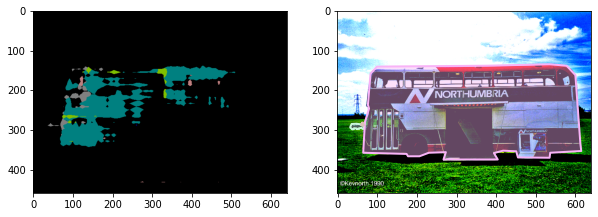

[{'license': 2, 'file_name': '000000468124.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000468124.jpg', 'height': 459, 'width': 640, 'date_captured': '2013-11-16 17:47:12', 'flickr_url': 'http://farm4.staticflickr.com/3452/3951591332_a116028f33_z.jpg', 'id': 468124}]


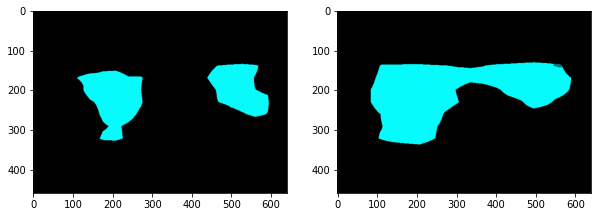

In [ ]:
idx = randint(4000, 5000-1)
imgId = 489305
imgId = inference_display(fcn50_pretrained, COCO, idx)
print(coco.loadImgs(imgId))
# pth2 = 'fcn50_finetune_auxlr2_lambda_ep0.pth'
# pth4 = 'fcn50_finetune_auxlr2_step_ep0.pth'
path1 = 'fcn_mobilenetv2_auxlr2_lambda_ep7.pth'
# path2 = 'deeplabv3_mobilenetv2_auxlr2_lambda_ep7.pth'
path3 = 'fcn_mobilenetv2_auxlr2_lambda_ep28.pth'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# display_preds(axes[0], fcn50_finetune, imgId, checkpoint=pth2)
# display_preds(axes[1], fcn50_finetune, imgId, checkpoint=pth4)
display_preds(axes[0], fcn_mobilev2, imgId, checkpoint=path1)
display_preds(axes[1], fcn_mobilev2, imgId, checkpoint=path3)

plt.show()

#### View performance change over epochs

In [ ]:
def display_preds_by_epoch(model, imgId, epochs, checkpoint, cols=5):
    rows = (epochs-1)//cols + 1 # ceil division
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    base = checkpoint.split('.')[0][:-1]
    for i in range(epochs):
        checkpoint = base + str(i) +'.pth'
        if rows > 1:
            display_preds(axes[i//cols][i%cols], model, imgId, checkpoint)
        else:  
            display_preds(axes[i], model, imgId, checkpoint)
    plt.show()
    fig.savefig(os.path.join('drive/MyDrive/data/preds/', str(imgId)+'_epochs.jpg'))
display_preds_by_epoch(fcn_mobilev3, imgId, 5, mobile_path2)

## Part 2: Federated learning (E/Jan)

### 1. make non-iid sampler [done]

### 2. Add coco data and model to federated model training

### 3. after codebase can run, move to pysyft, add differential privacy

### 4. add argument parses, run experiments, conclude

## Part 3: Project demo, with streamlit (M/Feb)

## Final: Project report (E/Feb)